## **FlexiBench Air Quality & Pollution Monitoring MLP Quantization**
### Author: Shvetank Prakash
### Date: Jan 2025
#### Dataset: [UCI Air Quality](https://archive.ics.uci.edu/dataset/360/air+quality)
#### Helpful links:

[Air Quality Index and Air Pollutant Concentration
Prediction Based on Machine Learning Algorithms](https://www.mdpi.com/2076-3417/9/19/4069) (Paper Results Modeled)

[Using neural networks for short-term prediction of air pollution levels
](https://ieeexplore.ieee.org/document/5227910) (Similar Application/Implementation)


[Waste Management and Prediction of Air Pollutants
Using IoT and Machine Learning Approach](https://www.mdpi.com/1996-1073/13/15/3930) (Similar Application/Implementation)

[Gemmlowp Paper](https://arxiv.org/pdf/1712.05877)

[Gemmlowp Implementation](https://github.com/google/gemmlowp/tree/master)


# Basic Imports and Global Defs

In [1]:
!pip install tensorflow-model-optimization==0.8.0
!pip install ucimlrepo==0.0.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 3.8 MB/s eta 0:00:00


In [2]:
import os
import csv
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_model_optimization as tfmot
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Setting environment variables
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
# Model Parameters
INPUT_SIZE = 2
HIDDEN_SIZE = 32
OUTPUT_SIZE = 1

# Training Parameters
EPOCHS = 100
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32
LEARNING_RATE = 0.001

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# **Read and Preprocess Dataset**

***Download Dataset from Kaggle [here](https://www.kaggle.com/datasets/fedesoriano/air-quality-data-set) and place in file directory of this notebook. As noted on the Kaggle page link, this dataset comes from the UCI ML Repository [here](https://archive.ics.uci.edu/dataset/360/air+quality).***

In [4]:
# from ucimlrepo import fetch_ucirepo

# # Fetch dataset
# air_quality = fetch_ucirepo(id=360)

# # Data (as pandas dataframes)
# data = air_quality.data.original[['CO(GT)', 'NOx(GT)', 'NO2(GT)']].astype('float32')  # select only the relevant columns

In [5]:
# Load the dataset downloaded from Kaggle link above (adopted from UCI ML Repository)
data = pd.read_csv('AirQuality.csv', delimiter=';', decimal=',')
data.columns = data.columns.str.strip()
data = data[['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S5(O3)', 'NMHC(GT)']]  # select only some columns based on correlation matrix from: https://www.mdpi.com/2076-3417/9/19/4069
data = data.dropna() # drop any rows with missing values
data = data[(data >= 0).all(axis=1)]  # remove rows with negative values in any of the selected columns

# Function to quantize data to uint8
def normalize(series):
    min_val = series.min()
    max_val = series.max()
    scaled = (series - min_val) / (max_val - min_val)
    return scaled

# Apply the normalization to all numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].apply(normalize)

# Save the quantized dataset to a new CSV file
data.to_csv('Normalized_AirQuality.csv', index=False)


In [6]:
data_path = 'Normalized_AirQuality.csv'  # read the quantized dataset for training
data = pd.read_csv(data_path, delimiter=',')
data = data[['CO(GT)', 'NOx(GT)', 'NO2(GT)']].astype('float32')  # select only the relevant columns

data = data.dropna()  # Drop any rows with missing values
data = data[(data >= 0).all(axis=1)]  # remove rows with negative values in any of the selected columns
# Note: we do not normalize column values between 0 and 1 for training as we empirically observe better training results when training directly on quantized uint8 data

# Predict NOx concentration from CO and NO2
X = data[['CO(GT)', 'NO2(GT)']].values
y = data['NOx(GT)'].values

# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)  # adjust test_size and random_state as needed

# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=len(X_train), seed=SEED).batch(BATCH_SIZE_TRAIN)
test_dataset = test_dataset.batch(BATCH_SIZE_TEST)

In [7]:
# Print one sample from train and test dataset each
print("Train Dataset Sample:")
for x, y in train_dataset.take(1):
    print(f"Inputs: {x}")
    print(f"Output:  {y}")

print("Test Dataset Sample:")
for x, y in test_dataset.take(1):
    print(f"Inputs: {x}")
    print(f"Output:  {y}")

Train Dataset Sample:
Inputs: [[0.20512821 0.42937854]
 [0.07692308 0.15254237]
 [0.14102565 0.40677965]
 [0.12820514 0.32768363]
 [0.23076923 0.47457626]
 [0.21794872 0.33898306]
 [0.2820513  0.53672314]
 [0.05128205 0.2937853 ]
 [0.15384616 0.34463277]
 [0.16666667 0.46327683]
 [0.07692308 0.2259887 ]
 [0.2820513  0.56497175]
 [0.35897437 0.46892655]
 [0.51282054 0.66101694]
 [0.35897437 0.4519774 ]
 [0.25641027 0.4858757 ]
 [0.2948718  0.45762712]
 [0.32051283 0.5141243 ]
 [0.1923077  0.40112993]
 [0.08974359 0.2937853 ]
 [0.11538462 0.2881356 ]
 [0.02564103 0.09039548]
 [0.17948718 0.50282484]
 [0.14102565 0.3220339 ]
 [0.55128205 0.7175141 ]
 [0.17948718 0.31638417]
 [0.41025642 0.5141243 ]
 [0.6025641  0.70621467]
 [0.14102565 0.3220339 ]
 [0.4871795  0.50282484]
 [0.20512821 0.36158192]
 [0.7948718  0.7175141 ]]
Output:  [0.20171674 0.06437768 0.14377682 0.15879828 0.24678111 0.16309012
 0.26824033 0.08583691 0.18025751 0.16523606 0.09656652 0.29613733
 0.3025751  0.472103   0.3

# **Create Model**

In [8]:
def create_mlp(input_size, hidden_size, output_size):
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(input_size,)),
        layers.Dense(hidden_size, activation='relu'),
        layers.Dense(output_size)
    ])
    return model

model = create_mlp(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129 (516.00 B)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 0 (0.00 B)

# **Train from Scratch in FP32**

In [9]:
# Initial non-quant training
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset
    )

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0356 - mae: 0.1409 - val_loss: 0.0147 - val_mae: 0.0864
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - mae: 0.0818 - val_loss: 0.0092 - val_mae: 0.0820
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - mae: 0.0810 - val_loss: 0.0066 - val_mae: 0.0689
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - mae: 0.0629 - val_loss: 0.0048 - val_mae: 0.0569
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0553 - val_loss: 0.0035 - val_mae: 0.0463
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - mae: 0.0431 - val_loss: 0.0029 - val_mae: 0.0420
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0423 - val_loss: 0.0026 - val_mae: 0.0388
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - mae: 0.0403 - val_loss: 0.0026 - val_mae: 0.0381
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0

# **Vizualize Training History**

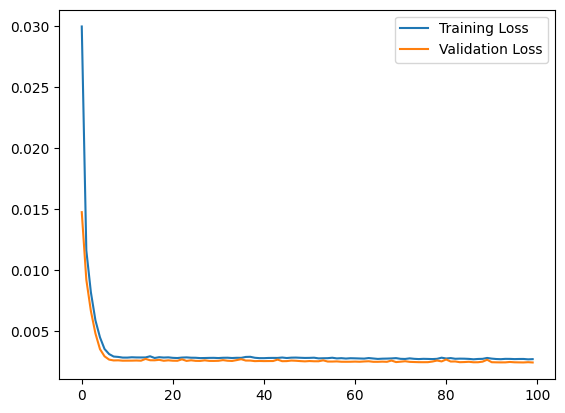

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# **Test Set Classification Accuracy of FP32 Model**

In [11]:
# Evaluate the FP32 model
results = model.evaluate(test_dataset)

# Print the results
print(f"Test Loss: {results[0]}, Test MAE: {results[1]}")

# Predict 1 hour ahead on the test set
y_pred = model.predict(X_test)

# Calculate R² score
r2 = r2_score(y_test, y_pred)
print(f'\nR² score: {r2}')

# Goal: Target R2 >= 0.88

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mae: 0.0354 
Test Loss: 0.002396773546934128, Test MAE: 0.03636900708079338
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

R² score: 0.9235679507255554


# **Convert to TFLite Model**

In [12]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Print tensor details
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
for tensor in interpreter.get_tensor_details():
    print(tensor['name'], tensor['dtype'])
    try:
        # Attempt to get tensor data
        tensor_data = interpreter.get_tensor(tensor['index'])
        print(tensor_data)
    except ValueError:
        # Skip tensors with null data
        print(f"Skipping tensor '{tensor['name']}' as it has null data.")

Saved artifact at '/tmp/tmpu7507xqn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134638545261328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134638545262096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134638545261136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134638545263248: TensorSpec(shape=(), dtype=tf.resource, name=None)
serving_default_keras_tensor:0 <class 'numpy.float32'>
[[4.9128376e-32 0.0000000e+00]]
arith.constant <class 'numpy.float32'>
[[ 0.5478622   0.06143686  0.22692907  0.32726082  0.27761656 -0.45524037
   0.2241812  -0.17943075 -0.3651709  -0.18907689 -0.23554206  0.01485139
   0.14334978  0.11927134  0.04392979 -0.39882535  0.20080668  0.28984806
  -0.30226865  0.053534    0.23917842  0.53367776  0.0925779   0.39441562
   0.20832723  0.3079624

# **Convert to Quantized Model**

In [13]:
# Provide a representative dataset to guide the quantization process
def representative_dataset_gen():
    for data, _ in test_dataset.unbatch().batch(1).take(100):
        yield [data]

# Convert the model to int8 format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.experimental_new_quantizer = False  # Optional: Use the default quantizer
converter._experimental_disable_per_channel = True
tflite_quant_model = converter.convert()

# Save the model
with open('model_quantized.tflite', 'wb') as f:
  f.write(tflite_quant_model)

# Print tensor details
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

for tensor in interpreter.get_tensor_details():
    print(tensor['name'], tensor['dtype'])
    try:
        # Attempt to get tensor data
        tensor_data = interpreter.get_tensor(tensor['index'])
        print(tensor_data)
    except ValueError:
        # Skip tensors with null data
        print(f"Skipping tensor '{tensor['name']}' as it has null data.")

Saved artifact at '/tmp/tmpbieevelh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134638545261328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134638545262096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134638545261136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134638545263248: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


serving_default_keras_tensor:0_int8 <class 'numpy.int8'>
[[-32  60]]
arith.constant <class 'numpy.int8'>
[[ 127   14   53   76   64 -106   52  -42  -85  -44  -55    3   33   28
    10  -92   47   67  -70   12   55  124   21   91   48   71   -7  -57
    33    6  -50   21]]
sequential_1/dense_1_2/Add/ReadVariableOp <class 'numpy.int32'>
[1006]
sequential_1/dense_1/Add/ReadVariableOp <class 'numpy.int32'>
[ 3679  -680     0  4065 -3252 10707   679  8886     0 -5100     0     0
   517     0  -259 -1294     0 -1436 -2625  -354     0  3627   165   831
   610     0     0     0   544    22     0   106]
sequential_1/dense_1/MatMul <class 'numpy.int8'>
[[  98  -73]
 [  52  -11]
 [ -31  -52]
 [ 125  -61]
 [ -70   67]
 [ -16  -54]
 [ 121   49]
 [ -91   17]
 [   5 -101]
 [  29    7]
 [ -91  -36]
 [ -12  -25]
 [ 120  109]
 [  -7  -20]
 [  26   16]
 [  51  -63]
 [-106  -83]
 [ -58   56]
 [  -7   16]
 [ -95    1]
 [-102 -104]
 [  99  -68]
 [ 110   73]
 [ -36   90]
 [  97   -6]
 [ -82  -41]
 [  -8 -103

# **Test Set Classification Accuracy of 8-bit Model**

---



In [14]:
# Test accuracy of quantized model
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define the transformation function
def convert_to_int8(X, y):
    # Multiply by 255 and subtract 128 cast to int8
    X = tf.cast((X * 255) - 128, tf.int8)
    y = tf.cast((y * 255) - 128, tf.int8)
    return X, y

# Apply the transformation to the dataset
test_dataset_quantized_inputs = test_dataset.map(convert_to_int8).unbatch()
test_dataset_quantized_targets = []  # list to store ground truth NO2 concentration values for calculating R² Score & MAE
predictions = []  # list to store predicted NO2 concentration values for calculating R² Score & MAE

# Example: Inspect the first batch
for X_batch, y_batch in test_dataset_quantized_inputs.take(1):
    print(X_batch.numpy(), y_batch.numpy())
for input, target in test_dataset_quantized_inputs.batch(1):
    interpreter.set_tensor(input_details[0]['index'], input.numpy().astype('int8'))
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(int(output))
    test_dataset_quantized_targets.append(int(target.numpy()))

print(f"Quantized Model Test Set MAE: {np.mean(np.abs(np.array(predictions) - test_dataset_quantized_targets))}")
print(f"Quantized Model Test Set R² Score: {r2_score(test_dataset_quantized_targets, np.array(predictions))}")

[-95 -31] -91
Quantized Model Test Set MAE: 15.096385542168674
Quantized Model Test Set R² Score: 0.8165994293630214


<ipython-input-14-884ca647e175>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions.append(int(output))
<ipython-input-14-884ca647e175>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_dataset_quantized_targets.append(int(target.numpy()))


In [15]:
# Load the quantized TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

# Extract tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
all_tensor_details = interpreter.get_tensor_details()

# Extract weights, biases, scales, and zero points from allocated tensors
quantized_params = {}
for tensor in all_tensor_details:
    # Check if the tensor has quantization parameters and valid data
    try:
        # Attempt to get tensor data
        tensor_data = interpreter.get_tensor(tensor['index'])

        if 'quantization_parameters' in tensor and tensor['quantization_parameters']['scales'].size > 0:
            quantized_params[tensor['name']] = {
                'values': tensor_data,
                'scale': tensor['quantization_parameters']['scales'],
                'zero_point': tensor['quantization_parameters']['zero_points']
            }
    except ValueError:
        # Skip tensors with null data
        if 'quantization_parameters' in tensor and tensor['quantization_parameters']['scales'].size > 0:
            quantized_params[tensor['name']] = {
                'scale': tensor['quantization_parameters']['scales'],
                'zero_point': tensor['quantization_parameters']['zero_points']
            }
        print(f"Skipping tensor '{tensor['name']}' as it has null data.")

print("Quantized parameters extracted.")

Skipping tensor 'sequential_1/dense_1/MatMul;sequential_1/dense_1/Relu;sequential_1/dense_1/Add' as it has null data.
Quantized parameters extracted.


# **Print Names, Weights, Scales, and Zero Points of Quantized Model Tensors'**

In [16]:
for name, params in quantized_params.items():
    print(f"{name} - Scale: {params['scale']}, Zero Point: {params['zero_point']}")
    if 'values' in params:
      print(params['values'])

serving_default_keras_tensor:0_int8 - Scale: [0.00361139], Zero Point: [-128]
[[0 0]]
arith.constant - Scale: [0.00431388], Zero Point: [0]
[[ 127   14   53   76   64 -106   52  -42  -85  -44  -55    3   33   28
    10  -92   47   67  -70   12   55  124   21   91   48   71   -7  -57
    33    6  -50   21]]
sequential_1/dense_1_2/Add/ReadVariableOp - Scale: [1.2981408e-05], Zero Point: [0]
[1006]
sequential_1/dense_1/Add/ReadVariableOp - Scale: [1.37996485e-05], Zero Point: [0]
[ 3679  -680     0  4065 -3252 10707   679  8886     0 -5100     0     0
   517     0  -259 -1294     0 -1436 -2625  -354     0  3627   165   831
   610     0     0     0   544    22     0   106]
sequential_1/dense_1/MatMul - Scale: [0.00382115], Zero Point: [0]
[[  98  -73]
 [  52  -11]
 [ -31  -52]
 [ 125  -61]
 [ -70   67]
 [ -16  -54]
 [ 121   49]
 [ -91   17]
 [   5 -101]
 [  29    7]
 [ -91  -36]
 [ -12  -25]
 [ 120  109]
 [  -7  -20]
 [  26   16]
 [  51  -63]
 [-106  -83]
 [ -58   56]
 [  -7   16]
 [ -95  

# **Map TFLite Provided Names to Intuitive Ones**
The TFLite Layer names after quantization are not very intuitive.
Use the names above + the [Netron](https://netron.app/) application to update dictionary below so that it is very clear which layer is which. *You may need to update the names if any changes are made to the notebook.*

In [17]:
# Layer name map
layer_name_map = {
    "input_layer": "serving_default_keras_tensor:0_int8",
    "layer_one_weights": "sequential_1/dense_1/MatMul",
    "layer_one_bias": "sequential_1/dense_1/Add/ReadVariableOp",
    "layer_one_output_activations": "sequential_1/dense_1/MatMul;sequential_1/dense_1/Relu;sequential_1/dense_1/Add",
    "layer_two_weights": "arith.constant",
    "layer_two_bias": "sequential_1/dense_1_2/Add/ReadVariableOp",
    "output_layer": "StatefulPartitionedCall_1:0_int8"
}

In [18]:
input_layer_scale = quantized_params[layer_name_map["input_layer"]]["scale"]
input_layer_zero_point = quantized_params[layer_name_map["input_layer"]]["zero_point"]

layer_one_weights = quantized_params[layer_name_map["layer_one_weights"]]["values"]
layer_one_weights_scale = quantized_params[layer_name_map["layer_one_weights"]]["scale"]
layer_one_weights_zero_point = quantized_params[layer_name_map["layer_one_weights"]]["zero_point"]
layer_one_bias = quantized_params[layer_name_map["layer_one_bias"]]["values"]

layer_one_output_activations_scale = quantized_params[layer_name_map["layer_one_output_activations"]]["scale"]
layer_one_output_activations_zero_point = quantized_params[layer_name_map["layer_one_output_activations"]]["zero_point"]

layer_two_weights = quantized_params[layer_name_map["layer_two_weights"]]["values"]
layer_two_weights_scale = quantized_params[layer_name_map["layer_two_weights"]]["scale"]
layer_two_weights_zero_point = quantized_params[layer_name_map["layer_two_weights"]]["zero_point"]
layer_two_bias = quantized_params[layer_name_map["layer_two_bias"]]["values"]

output_layer_scale = quantized_params[layer_name_map["output_layer"]]["scale"]
output_layer_zero_point = quantized_params[layer_name_map["output_layer"]]["zero_point"]

In [19]:
def calculate_fixed_point_multiplier(input_scale, weight_scale, output_scale):
    # Calculate M0 and N from M = 2^-N M0 = (S1 * S2 / S3)
    multiplier = input_scale * weight_scale / output_scale
    shift = 0
    while multiplier < 0.5:
        multiplier *= 2
        shift += 1
    quantized_multiplier = multiplier * math.pow(2, 31)
    return quantized_multiplier, shift

In [20]:
# First layer requantization params
layer_one_multiplier, layer_one_shift = calculate_fixed_point_multiplier(input_layer_scale, layer_one_weights_scale, layer_one_output_activations_scale)

# Second layer requantization params
layer_two_multiplier, layer_two_shift = calculate_fixed_point_multiplier(layer_one_output_activations_scale, layer_two_weights_scale, output_layer_scale)

subscript_printing = str.maketrans("123456789", "₁₂₃₄₅₆₇₈₉")
print("Layer 1 Requantization Params:")
print("M01: ".translate(subscript_printing) + f"{layer_one_multiplier[0]:.2f}")
print("N1: ".translate(subscript_printing)  + f"{layer_one_shift}")

print("Layer 2 Requantization Params:")
print("M02: ".translate(subscript_printing) + f"{layer_two_multiplier[0]:.2f}")
print("N2: ".translate(subscript_printing)  + f"{layer_two_shift}")

Layer 1 Requantization Params:
M0₁: 1260531456.00
N₁: 7
Layer 2 Requantization Params:
M0₂: 1165263744.00
N₂: 7


# **Emulate 8-bit Integer Inference with Numpy**

In [21]:
# Create copy of test dataset
TEST_SET_SIZE = 166
test_dataset_copy = (iter(test_dataset_quantized_inputs.take(TEST_SET_SIZE)))

In [22]:
def run_tflite_golden_inference(tflite_model, inputs, debug=False):
    #
    # Golden Reference Implementation of TFLite Inference running on a single sample
    #

    # Add batch dim to single data sample
    inputs = np.expand_dims(inputs, 0)

    # Load TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_content=tflite_model, experimental_preserve_all_tensors=True)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Load input tensor
    interpreter.set_tensor(input_details[0]['index'], inputs)

    # Run the model
    interpreter.invoke()

    # Print each layer's output if needed for verification
    if debug:
      print({
          t['name']: interpreter.get_tensor(t['index'])
          for t in interpreter.get_tensor_details()
      })

    return interpreter.get_tensor(output_details[0]['index'])

In [23]:
def run_numpy_inference(input):
  #
  # Numpy Reference Implementation of TFLite Inference running on a single sample
  #

  # (Inputs * Layer 1 Weights) + Bias followed by ReLU
  x = np.matmul((input.numpy().astype(np.int32) - input_layer_zero_point.astype(np.int32)),(layer_one_weights.T.astype(np.int32) - layer_one_weights_zero_point.astype(np.int32)))
  x = x + layer_one_bias
  x = np.maximum(x, 0)

  # Requantization pipeline
  x = x * layer_one_multiplier
  x = np.round((x / np.power(2,31))).astype(np.int32)
  x = np.round((x / np.power(2, layer_one_shift))).astype(np.int32)
  x = x + layer_one_output_activations_zero_point.astype(np.int32)
  x = np.clip(x, -128, 127)

  # (Layer 1 Activations * Layer 2 Weights) + Bias
  x = np.matmul((x.astype(np.int32) - layer_one_output_activations_zero_point.astype(np.int32)), (layer_two_weights.T.astype(np.int32) - layer_two_weights_zero_point.astype(np.int32)))
  x = x + layer_two_bias

  # Requantization pipeline
  x = x * layer_two_multiplier
  x = np.round((x / np.power(2,31))).astype(np.int32)
  x = np.round((x / np.power(2, layer_two_shift))).astype(np.int32)
  x = x + output_layer_zero_point.astype(np.int32)
  x = np.clip(x, -128, 127)

  return x


In [24]:
tflite_predictions = []
numpy_predictions = []
ground_truth = []

for inputs, targets in test_dataset_copy:
  tflite_output = run_tflite_golden_inference(tflite_quant_model, inputs.numpy().astype(np.int8))
  numpy_output = run_numpy_inference(inputs)
  tflite_predictions.append(int(tflite_output))
  numpy_predictions.append(int(numpy_output))
  ground_truth.append(int(targets.numpy()))
  # Make sure that raw values of output tensors match exactly to validate numpy reference implementation
  if np.array_equal(tflite_output.flatten()[0], numpy_output.flatten()):
    print(tflite_output)
    print(numpy_output)
    print("ERROR: TFlite Golden Output Tensor does not match Numpy Implementation Output Tensor")

# Make sure accuracy is exactly the same to validate numpy implementation
tflite_r2_score = r2_score(ground_truth, tflite_predictions)
numpy_r2_score = r2_score(ground_truth, numpy_predictions)
print(f"TF Lite R² score: {tflite_r2_score}")
print(f"Numpy R² score: {numpy_r2_score}")
print("Numpy Implementation matches TFLite Golden Implementation!" if abs(tflite_r2_score - numpy_r2_score) <= 1e4 else "Numpy Implementation does NOT match TFLite Golden Implementation!")

<ipython-input-24-782384067832>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tflite_predictions.append(int(tflite_output))
<ipython-input-24-782384067832>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  numpy_predictions.append(int(numpy_output))


TF Lite R² score: 0.8164144775839145
Numpy R² score: 0.8165725815241187
Numpy Implementation matches TFLite Golden Implementation!


# **Write Test Set Data to CSV for C Implementation in Flexibench Repository**

In [25]:
def dump_test_data_to_csv(dataset, headers, filename):
  with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    tflite_predictions = []
    ground_truth = []
    for inputs, targets in dataset:
      # Write the original TFLite model prediction along with inputs and ground truth label to the CSV for reference
      tflite_model_output = run_tflite_golden_inference(tflite_quant_model, inputs)
      tflite_predictions.append(int(tflite_model_output))
      ground_truth.append(int(targets.numpy()))
      writer = csv.writer(csvfile)
      writer.writerow(np.append(inputs.numpy(), [int(tflite_model_output), targets.numpy()]))
    print(f"TF Lite R² score: {r2_score(ground_truth, tflite_predictions)}")
    print("CSV saved.")

column_names = ['CO(GT)'] + ['NO2(GT)'] + ['TFLite_Model_Prediction'] + ['NOx(GT)_Golden_Label']
dataset_copy_for_csv = iter(test_dataset_quantized_inputs.take(TEST_SET_SIZE))
dump_test_data_to_csv(dataset_copy_for_csv, column_names, 'samples.csv')

<ipython-input-25-dde715989c1c>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tflite_predictions.append(int(tflite_model_output))
<ipython-input-25-dde715989c1c>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  writer.writerow(np.append(inputs.numpy(), [int(tflite_model_output), targets.numpy()]))


TF Lite R² score: 0.8164144775839145
CSV saved.
